# 聚宽回测平台介绍

## 1. 工具函数

首先导入本文档需要使用的库。

In [4]:
from jqfactor import get_factor_values, neutralize, winsorize_med, standardlize
from jqfactor import Factor, calc_factors

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr,pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import time

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [5]:
def get_near_trade_day(date, count):
    """
    获取相邻的交易日。

    参数:
    date (Timestamp)：当天交易日，年月日。
    count (int)：交易日相隔数，负数代表前，正数代表后。

    返回:
    Timestamp：上一个或下一个交易日，年月日。
    """
    # 获取上一个交易日
    if count < 0:
        df = get_price('000001.XSHG', end_date=date, count=abs(count) + 1)
        return df.index[0]
    
    # 获取下一个交易日
    elif count > 0:
        df = get_price('000001.XSHG', start_date=date, end_date=datetime.date.today())
        return df.index[count]
    
    # 如果 count == 0，返回原日期
    return date


In [6]:
def plot_return(df):
    """
    绘制收益率曲线图
    
    params:
    df(dataframe): 每日收益率数据，pd.DataFrame(index=[dates], columns=[portfolios])
    """
    num_ticks = 12
    plt.figure(figsize=(18,6))
    cum_return = (1 + df).cumprod() - 1
    for col in df.columns: 
        plt.plot(df.index, cum_return[col] * 100, label=col)
    dates = pd.to_datetime(df.index, unit="ms")
    ticks = np.linspace(0, len(dates) - 1, num_ticks, dtype=int)
    plt.xticks(dates[ticks])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

In [7]:
def count_time(func, *args, number):
    """
    计时器
    """
    start_time = time.time()
    for _ in range(number):
        func(*args)
    end_time = time.time()
    return end_time - start_time

## 2. 获取数据

为了更高效地获取数据，我们可以编写一些常用地函数，包括获取交易日、筛选股票、获取因子值、获取股票每期对应地因子值和收益率。

### 2.1 获取交易日

利用聚宽内置的 `get_price` 函数获取某只股票的行情数据，其索引可以作为交易日历。

输入：start_date（起始日期），end_date（终止日期），freq（频率），count（None）

In [8]:
# 1.1-获取交易日
def get_calendar(start_date=None, end_date=None, freq='D', count=None):
    """
    params:
    start_date(Timestamp)：起始日期，年月日
    end_date(Timestamp)：终止日期，年月日
    freq(str)：交易日频率，默认每天
     - 'W': 每周
     - 'M': 每月
     - 'Q': 每季度
     - 'Y': 每年
    count(int)：获取终止日期前交易日数量
    
    return:
    df.index(DatetimeIndex)：交易日索引列表
    """
    # 调整时间格式
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # 时间区间
    if count != None:
        df = get_price('000001.XSHG', end_date=end, count=count)
    else:
        df = get_price('000001.XSHG', start_date=start, end_date=end)
    
    # 时间周期
    end_day = df.index
    df[freq] = df.index.to_period(freq).start_time
    end_day = df.groupby(freq).apply(lambda x: x.index.max())
        
    return pd.to_datetime(end_day.values)

In [9]:
# 例子
start = "20230101"
end = "20231231"
get_calendar(start, end, freq='M')

DatetimeIndex(['2023-01-31', '2023-02-28', '2023-03-31', '2023-04-28',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-28', '2023-10-31', '2023-11-30', '2023-12-29'],
              dtype='datetime64[ns]', freq=None)

### 2.2 筛选股票函数

投资范围的确定包括原始股票池和优化股票池两步。原始股票池限定了最原始的投资范围，指明可供选择的股票有哪些。

确定了原始股票池后进入第二步，对其进行优化。在初始投资范围的基础上，为了防止掉坑踩雷，通常会进一步剔除掉有缺陷的股票，得到更加干净的股票池。有三类股票应该被剔除

- ST股
- 次新股
- 开盘涨跌停股

ST股是指市场中被特别处理的股票，通常因为公司财务状况不佳或其他重大问题被标记为“ST” (Special Treatment)。ST股公司通常面临退市的风险，财务状况极度不稳定，容易发生无法预料的重大变动。

次新股指的是刚刚上市不久的股票，由于刚上市，公司还处在股价的价格发现阶段，次新股的价格波动较大，容易受到市场情绪、投资者预期以及消息面影响。

开盘涨跌停股指的是在开盘时就触及涨停板或跌停板的股票。涨跌停的股票流动性极差，交易难以进行，尤其是跌停时，市场缺乏买入意愿，可能导致无法及时卖出或买入。另外，涨跌停板的股票往往反映市场的极端情绪，无论是极端乐观还是极端悲观，这种非理性的波动难以预测且不具备持续性。

In [10]:
# 1.2-筛选股票函数
def filter_stock(stock_list, date, days=21*3, limit=1):
    """
    params:
    stock_list (list)：股票序列列表，["600000.XSHG", ...]
    date (Timestamp)：交易日，年月日
    days (int)：过滤次新股时间
    limit (int)：过滤涨跌停开关，1/0
    
    return:
    stock_list (list)：过滤后的股票序列列表，["600000.XSHG", ...]
    """
    date = pd.to_datetime(date)
    
    # 除上市距beginDate不足3个月的股票
    def _delete_new(stocks, begin_date, n=days):
        filtered_list = []
        for stock in stocks:
            start_date = get_security_info(stock).start_date
            if start_date < (begin_date - pd.Timedelta(days=n)).date():
                filtered_list.append(stock)
        return filtered_list
    
    # 剔除ST股
    st_data = get_extras('is_st', stock_list, count=1, end_date=date)
    stock_list = [stock for stock in stock_list if not st_data[stock][0]]
    
    # 剔除次新股
    stock_list = _delete_new(stock_list, date, n=days)

    # 剔除开盘涨停股票
    if limit == 1:
        df = get_price(stock_list, end_date=date, fields=['open', 'high_limit', 'low_limit'], 
                       count=1, skip_paused=True, panel=False)
        df = df.set_index("code")
        df['h_limit'] = (df['open'] != df['high_limit'])
        df['l_limit'] = (df['open'] != df['low_limit'])
        # 过滤开盘涨跌停股票
        stock_list = [i for i in df.index if (df.loc[i, "h_limit"] and df.loc[i, "l_limit"])]

    return stock_list

In [11]:
# 例子
stockList = list(map(normalize_code, ["301136", "000586", "300125"]))

# 301136为2022-01-11上市
print("剔除次新股：", filter_stock(stockList, "20220102"))

# 300125在2024-06-10为ST股
print("剔除ST股：", filter_stock(stockList, "20240610"))

# 000586在2024-08-07开盘涨停
print("剔除开盘涨跌停股：", filter_stock(stockList, "20240807"))

剔除次新股： ['000586.XSHE', '300125.XSHE']
剔除ST股： ['301136.XSHE', '000586.XSHE']
剔除开盘涨跌停股： ['301136.XSHE']


### 2.3 获取因子值函数

joinquant中有两类因子：因子库、定义因子

文档：

- [因子库](https://www.joinquant.com/help/api/help#name:factor_values)
- [定义因子](https://www.joinquant.com/help/api/help#factor:%E5%9B%A0%E5%AD%90%E5%88%86%E6%9E%90API)

其中因子库为joinquant内置，输入字符串即可获取。定义因子是继承Factor类后自己定义的因子，本质上是一个子类。

In [12]:
# 1.3-获取因子值函数，必须全部为聚宽因子或全部为定义因子
# 可以分别获取后再合并
def get_factor_df(stock_list, factor_list, date):
    """
    params:
    stock_list(list)：股票序列列表，["600000.XSHG",...]
    factor_list(list)：因子名称列表，["residual_volatility",...]
    date(Timestamp)：交易日，年月日（取前一日的因子值）
    
    return:
    df(DataFrame)：因子数据集，pd.DataFrame(index=[stock_list], columns=[factor_list])
    """
    date = pd.to_datetime(date)
    
    # 取前一天的数据
    last_date = get_near_trade_day(date, -1)
    
    if type(factor_list[0]) == str:
        factor_data = get_factor_values(securities=stock_list, factors=factor_list, 
                                        end_date=last_date, count=1)
    # 如果是定义因子像ep()这种，需要因子计算
    else:
        factor_data = calc_factors(securities=stock_list, factors=factor_list, start_date=last_date, 
                                   end_date=last_date, use_real_price=False, skip_paused=True)
        factor_list = [factor.name for factor in factor_list]
        
    df = pd.concat([pd.DataFrame(factor_data[f]).T for f in factor_list], axis=1)
    df.columns = factor_list
    
    return df

In [13]:
# 例子
stock_list = list(map(normalize_code, ["301136", "000586", "300125"]))
factor_list = ["beta", "size", "momentum"]
get_factor_df(stock_list, factor_list, "20240701")

,beta,size,momentum
code,,,
301136.XSHE,2.435321,-2.257106,-1.057598
000586.XSHE,2.069847,-2.969061,-1.214831
300125.XSHE,2.515297,-4.036516,-3.761750


### 2.4 获取每期股票对应的因子值和收益率

输入日期，因子，以及股票池；对每天的因子值进行去极值（winsorize）、行业市值中性化（neutralize）、标准化（standardlize），至此因子预处理完成。

接着考虑下期收益率。不存在滞后算子时（lag=0）

$$
R_t=\frac{P_{t+1}}{P_t}
$$

若引入滞后算子$i\neq 0$，则

$$
R_t^i=\frac{P_{t+1+i}}{P_t}
$$

所以如果时间序列为$t_1,t_2,t_3,t_4,t_5$，则lag=0时收益率数据只有四个$R_1,R_2,R_3,R_4$，lag=1时只有三个$R_1^1,R_2^1,R_3^1$，以此类推。

```python
(len(date_list) - 1) - i - 1 < lag_i
```

左式为结束日期到当前日期的距离，右式为收益率跨度

验证：当lag_i = 0时，到最后一个时间点，即 `i=(len(date_list)-1)-1`，此时0<0=False，存在即期收益率，正确。

In [14]:
# 1.4-获取每期股票对应的因子值和收益率
def get_fac_ret_dict(date_list, factor_list, index_code=None, lag_num=5):
    """
    params:
    date_list (list)：交易日列表
    factor_list (list)：因子名称列表，如 ["residual_volatility", ...]
    index_code (str)：指数代码，表示股票池，None 表示全市场池
    lag_num (int)：收益率延期期数，方便后续计算因子 IC 半衰期
    
    return:
    dict：因子数据集的时间字典，格式为 {date: pd.DataFrame(index=[stock_list], columns=[factor_list + yield])}
    """
    data_dict = {}
    lag_num_list = list(range(lag_num + 1))
    
    # 删掉最后一期（需要下期收益率）
    for i in range(len(date_list) - 1):
        day = date_list[i]
        
        # 选择股票池
        pool = get_index_stocks(index_code, day) if index_code else get_all_securities(date=day).index

        # 过滤股票
        pool = filter_stock(pool, day)
        
        # 获取因子数据
        df = get_factor_df(pool, factor_list, day).dropna(axis=0, how='any')
        pool = df.index.tolist()
        
        # 异常值处理：中位数法
        df = winsorize_med(df, scale=3, inclusive=True, inf2nan=True, axis=0)
        
        # 行业市值中性化
        df = neutralize(df, how=['sw_l1', 'market_cap'], date=day, axis=0)
        
        # 标准化
        df = standardlize(df, inf2nan=True, axis=0)
        
        # 获取当天价格
        price = get_price(pool, count=1, end_date=day, skip_paused=True, panel=False, fields=['close'])['close']
        
        # 计算延期收益率（每个lag单独算）
        for lag_i in lag_num_list:
            # 剩余天数不足lag，用0填充
            if (len(date_list) - 1) - i < lag_i + 1:
                df[lag_i] = np.zeros(len(pool))
            else:
                next_day = date_list[i + 1 + lag_i]
                next_price = get_price(pool, count=1, end_date=next_day, skip_paused=True, 
                                       panel=False, fields=['close'])['close']
                df[lag_i] = next_price.values / price.values - 1
        
        data_dict[day] = df
    
    return data_dict

In [16]:
date_list = get_calendar(end_date="20240807", count=60, freq='W')
factor_list = ["beta", "size", "momentum"]
index_code = '000300.XSHG'
fac_ret_dict = get_fac_ret_dict(date_list, factor_list, index_code)
date = date_list[5]
print(f"{date} 因子值和收益率")
fac_ret_dict[date].head()

2024-06-21 00:00:00 因子值和收益率


,beta,size,momentum,0,1,2,3,4,5
code,,,,,,,,,
000001.XSHE,0.716460,0.569768,-0.579750,0.015000,-0.003000,0.031000,0.037000,0.003000,0.014000
000002.XSHE,0.640406,0.438910,-0.987371,-0.036161,-0.043115,-0.033380,-0.018081,-0.048679,-0.052851
000063.XSHE,1.509532,1.183595,-0.655145,0.000366,-0.016850,0.023443,0.029670,-0.013553,-0.025275
000100.XSHE,-0.755233,0.651778,0.740881,0.018868,-0.004717,0.009434,-0.061321,-0.087264,-0.091981
000157.XSHE,-0.559411,-0.672491,0.715088,-0.026596,-0.063830,-0.057181,-0.074468,-0.102394,-0.125000


## 3. 因子有效性测试

### 3.1 IC测试

IC衡量预测变量的预测能力，其定义通常为$t+1$时刻的预测收益率与真实收益率在截面上的相关系数。

实操中，$t+1$时刻的预测收益率常用$t$时刻的预测变量代替（也就是因子值）

In [31]:
# 2.1 因子IC测试
def factor_IC_test(_fac_ret_dict, _factor_list):
    date_list = list(_fac_ret_dict.keys())
    IC_df = pd.DataFrame(0, index=date_list, columns=_factor_list)
    IC_stats_df = pd.DataFrame(0, index=["IC_mean", "IC_std", "IR", "sig_prop", "t-value"], columns=_factor_list)
    for date in date_list:
        for factor in _factor_list:
            fac_ret_df = _fac_ret_dict[date][[factor, 0]]
            ic, p_value = spearmanr(fac_ret_df.loc[:, factor], fac_ret_df.loc[:, 0])
            IC_df.loc[date, factor] = ic

    IC_stats_df.loc["IC_mean"] = IC_df.mean(axis=0)
    IC_stats_df.loc["IC_std"] = IC_df.std(axis=0)
    IC_stats_df.loc["IR"] = IC_df.mean(axis=0) / IC_df.std(axis=0)
    IC_stats_df.loc["sig_prop"] = np.sum(np.abs(IC_df) > 0.02, axis=0) / np.count_nonzero(IC_df, axis=0)
    IC_stats_df.loc["t-value"] = IC_df.mean(axis=0) / IC_df.std(axis=0) * np.sqrt(len(IC_df))
    
    return IC_df, IC_stats_df

In [32]:
IC_df, IC_stats_df = factor_IC_test(fac_ret_dict, factor_list)
IC_df.head()

,beta,size,momentum
2024-05-17,-0.208500,0.056870,0.114491
2024-05-24,-0.106488,-0.011449,-0.013559
2024-05-31,-0.274823,0.185290,0.313269
2024-06-07,0.136722,-0.059606,-0.052470
2024-06-14,-0.184472,0.152148,0.299300


In [33]:
IC_stats_df

,beta,size,momentum
IC_mean,-0.058974,0.022510,0.025554
IC_std,0.141956,0.095083,0.184682
IR,-0.415435,0.236741,0.138367
sig_prop,1.000000,0.833333,0.916667
t-value,-1.439109,0.820095,0.479318


### 3.2 因子分组并计算组合收益率

需要IC测试判断因子和收益率相关性的正负，再分组并构建投资组合

In [38]:
# 2.2-因子分组并计算投资组合收益率
def get_group_portfolio_dict(_data_dict, _factor_list, neg_corr_fac_list, group_num=5, weight_method="avg", index_code="000300.XSHG"):
    """
    params:
    _data_dict(dict)：因子值数据集的时间字典，{date：pd.DataFrame(index=[stock_list], 
                                            columns=[_factor_list + yield(0)])}
    _factor_list(list)：因子名称列表，["residual_volatility",...]
    neg_corr_fac_list(list)：与收益率为负相关的因子名称列表
    group_num(int)：因子分组的组数，其中第0组为不分组
    weight_method(str)：投资组合股票权重类型
    index_code(str): 基准指数
    
    return:
    group_factor_dict(dict): 分组因子值数据集的时间字典，{date：pd.DataFrame(columns=[group_num])}
    group_yield_dict(dict): 分组股票收益率数据集的时间字典，{date：pd.DataFrame(columns=[group_num])}
    portfolio_yield_dict(dict): 分组投资组合收益率的时间字典，
    {date：pd.DataFrame(index=[date], columns=[0 + group_num + index + long_short])}
    """
    date_list = list(_data_dict.keys())
    
    # 初始化字典：分组后的因子暴露和股票收益率
    group_factor_dict = dict.fromkeys(_factor_list)
    group_yield_dict = dict.fromkeys(_factor_list)
    for factor in _factor_list:
        # 每个value是新的字典 {date: None}
        group_factor_dict[factor] = dict([(k, None) for k in date_list])
        group_yield_dict[factor] = dict([(k, None) for k in date_list])

    # 初始化字典：投资组合的收益率
    group_list = list(range(group_num + 1)) # 0代表不分组
    portfolio_yield_dict = {}
    for factor in _factor_list:
        portfolio_yield_dict[factor] = pd.DataFrame(data=None, index=date_list, columns=group_list)
    
    # 遍历每个时间点的因子值&资产收益率
    for date, data in _data_dict.items():
        # 遍历每个因子
        for factor in _factor_list:
            # 如果因子与收益负相关
            is_ascending = factor in neg_corr_fac_list
            
            # 若IC<0, 则升序排列；若IC>0, 则降序排列（收益率理应更高的股票排在前面）
            all_stock = data.sort_values(factor, ascending=is_ascending).index
            lens = len(all_stock)
            
            # 无法被组数整除的部分用nan填充
            nan_num = np.full(group_num - lens % group_num, np.nan)

            # 股票分组，不足的补全nan值（用reshape分组）
            all_stock_filled = np.append(all_stock, nan_num)
            group_stock = all_stock_filled.reshape((group_num, -1)).T
            
            # 股票收益率分组
            yield_ = data.loc[list(all_stock), 0].values
            yield_filled = np.append(yield_, nan_num)
            group_yield = yield_filled.reshape((group_num, -1)).T
            
            # 股票因子值分组
            factor_ = data.loc[list(all_stock), factor].values
            factor_filled = np.append(factor_, nan_num)
            group_factor = factor_filled.reshape((group_num, -1)).T
            
            # 分组后股票对应因子和对应收益率
            group_factor_dict[factor][date] = pd.DataFrame(data=group_factor, columns=group_list[1:])
            group_yield_dict[factor][date] = pd.DataFrame(data=group_yield, columns=group_list[1:])
            if weight_method == "mktcap":
                # 分组后市值加权投资组合收益率
                size_ = get_factor_values(securities=list(all_stock), factors=["market_cap"], end_date=date, 
                                          count=1)["market_cap"]
                size0 = size0.applymap(lambda x: x ** -0.333).values # 照顾小市值
                size_filled = np.append(size_, nan_num)
                size_grouped = size_filled.reshape((group_num, -1)).T # 将市值分组，得到每组市值
                # 不分组，整体的收益
                portfolio = np.nansum(yield_ * (size_ / np.nansum(size_)))
                # 分组，每组的收益（组内的股票共用一个权重）
                portfolio_group = np.nansum(group_yield * (size_grouped / np.nansum(size_grouped, axis=0)), axis=0)
                # columns=[0, 1, 2, ..., n], with n groups
                portfolio_yield_dict[factor].loc[date, :] = np.append(portfolio, portfolio_group)
            else:
                # 分组后等权投资组合收益率
                portfolio = np.nanmean(yield_)
                portfolio_group = np.nanmean(group_yield, axis=0)
                portfolio_yield_dict[factor].loc[date, :] = np.append(portfolio, portfolio_group)
                
    # 将未分组、指数、多空组合统计进入投资组合中
    # date_list(_data_dict的键)删减了最后一个交易日，计算收益率需要补回来
    end_date = get_near_trade_day(date_list[-1], 1)
    index_price = get_price(index_code, start_date=date_list[0], end_date=end_date, skip_paused=True, 
                            panel=False, fields=['open'])
    date_list.append(end_date)
    index_price = index_price.loc[date_list, "open"]
    for factor in _factor_list:
        portfolio_yield_dict[factor]["index"] = (index_price / index_price.shift(1)).dropna(axis=0, how='any').values - 1
        # 第一组 - 最后一组
        portfolio_yield_dict[factor]["long_short"] = portfolio_yield_dict[factor][1] - portfolio_yield_dict[factor][group_num]
        
    return group_factor_dict, group_yield_dict, portfolio_yield_dict

In [85]:
data_dict = fac_ret_dict.copy()
factor_list = factor_list.copy()
neg_corr_fac_list = ["beta"]
group_factor_dict, group_yield_dict, portfolio_yield_dict = get_group_portfolio_dict(data_dict, factor_list, neg_corr_fac_list)
print(f"group_factor_dict: beta, {date_list[5]}")
group_factor_dict["beta"][date_list[5]].head(10)  # row as stocks(not the same in each row!), column as groups

group_factor_dict: beta, 2024-06-21 00:00:00


,1,2,3,4,5
0,-3.127815,-0.782981,-0.220503,0.241513,0.899368
1,-2.608957,-0.777437,-0.217409,0.263952,0.905673
2,-2.466028,-0.771171,-0.213984,0.270753,0.906024
3,-2.379335,-0.770582,-0.209276,0.295320,0.926811
4,-2.236061,-0.755233,-0.204300,0.318216,0.939260
5,-2.146409,-0.753317,-0.200050,0.318709,0.942325
6,-2.138083,-0.748938,-0.196521,0.328538,0.945144
7,-1.982549,-0.728641,-0.196068,0.352257,0.968289
8,-1.951236,-0.672973,-0.195188,0.358029,0.974325
9,-1.912529,-0.669878,-0.190616,0.370640,0.985332


In [86]:
print(f"group_yield_dict: beta, {date_list[5]}")
group_yield_dict["beta"][date_list[5]].head(10)

group_yield_dict: beta, 2024-06-21 00:00:00


,1,2,3,4,5
0,0.015873,-0.054359,0.015328,0.005828,-0.004678
1,-0.029513,0.015817,-0.017335,0.054304,-0.030735
2,-0.038543,-0.097788,0.025758,0.003311,-0.072949
3,-0.059705,-0.009297,-0.072324,0.011792,-0.039123
4,0.056701,0.018868,-0.053505,-0.033629,-0.011364
5,-0.004926,-0.024651,-0.072303,0.013011,-0.063488
6,0.060438,0.042201,0.040793,0.053456,0.007519
7,-0.020833,-0.081037,-0.095761,-0.035380,-0.101844
8,-0.010228,0.048269,-0.039514,-0.073384,-0.038304
9,-0.063094,0.000000,0.013255,-0.039593,-0.027425


In [87]:
print(f"portfolio_yield_dict: beta")
portfolio_yield_dict["beta"]

portfolio_yield_dict: beta


,0,1,2,3,4,5,index,long_short
2024-05-17,-0.0212019,-0.0212385,-0.0172659,-0.0110899,-0.024375,-0.0330077,-0.002124,0.0117692
2024-05-24,-0.0026993,-0.00157968,5.88723e-05,0.00493396,-0.014688,-0.00217902,-0.008541,0.00059934
2024-05-31,-0.00422427,0.0113847,-0.00175829,0.000561831,-0.0162851,-0.0159888,-0.001442,0.0273735
2024-06-07,-0.00109651,-0.00648105,-0.00998194,6.14662e-05,7.22157e-05,0.0119131,-0.022208,-0.0183942
2024-06-14,-0.0165621,-0.00675819,-0.016695,-0.0076833,-0.0241726,-0.0284781,-0.005252,0.0217199
2024-06-21,-0.0169605,-0.012736,-0.010357,-0.0100194,-0.0143996,-0.0391058,-0.015064,0.0263698
2024-06-28,-0.0133534,-0.0159938,-0.00656651,-0.00745181,-0.0158852,-0.0215409,-0.000090,0.00554702
2024-07-05,0.0163921,0.0105308,0.0197113,0.00671937,0.0250903,0.0202228,0.004821,-0.00969201
2024-07-12,0.0231685,0.0313948,0.0179932,0.015852,0.0219193,0.0291754,0.011806,0.00221932
2024-07-19,-0.0316384,-0.0362365,-0.0269216,-0.0324149,-0.0317956,-0.0307507,-0.027736,-0.00548579


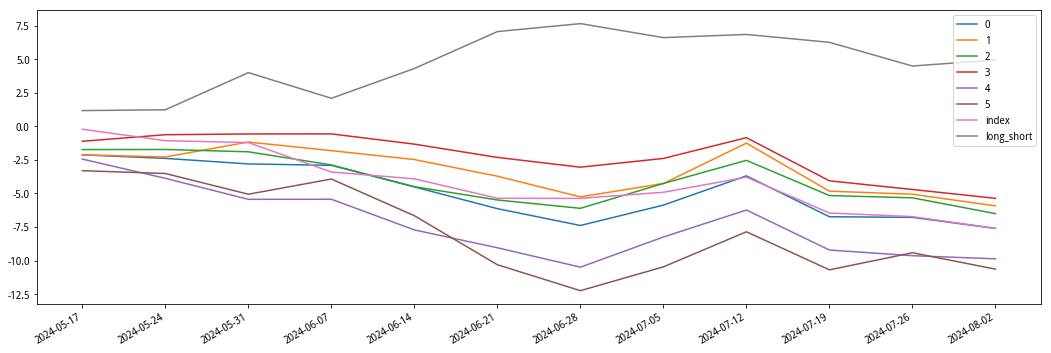

In [88]:
plot_return(portfolio_yield_dict["beta"])

*参考资料*

- [因子研究框架—收益模型篇](https://www.joinquant.com/community/post/detailMobile?postId=43978)
- [自定义python库](https://www.joinquant.com/view/community/detail/92d3af8a25c56640479abe2d5b6f7d81)
- 《因子投资 - 方法与实践》
- [API文档](https://www.joinquant.com/help/api/help#name:api)
- [因子库](https://www.joinquant.com/help/api/help#name:factor_values)
- [因子分析（定义因子）](https://www.joinquant.com/help/api/help#factor:%E5%9B%A0%E5%AD%90%E5%88%86%E6%9E%90API)
